In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./data"))

# Any results you write to the current directory are saved as output.

['test', 'labels.csv', 'train']


In [2]:

from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import cv2
import random

In [4]:
path_root = './data'
path_train = os.path.join(path_root, 'train')
path_test = os.path.join(path_root, 'test')
path_labels_csv = os.path.join(path_root, 'labels.csv')
path_result_csv = os.path.join(path_root, 'sample_submission.csv')

len_train = len(os.listdir(path_train))
len_test = len(os.listdir(path_test))

In [5]:
labels = pd.read_csv(path_labels_csv)
print(labels.head(5))

breed = list(set(labels['breed']))
n_classes = len(breed)
print(n_classes, len(os.listdir(path_train)))

labels.shape

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
120 10222


(10222, 2)

In [6]:
class_to_num = dict(zip(breed, range(n_classes)))
num_to_class = dict(zip(range(n_classes), breed))

In [7]:
width = 300
X_train = np.zeros((len_train, width, width, 3), dtype = np.uint8)
y_train = np.zeros((len_train, n_classes))
n = len(labels)

for i in tqdm(range(n)):
    X_train[i] = cv2.resize(cv2.imread(os.path.join(path_train, '%s.jpg' % labels['id'][i])), dsize = (width, width))
    y_train[i][class_to_num[labels['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:29<00:00, 347.57it/s]


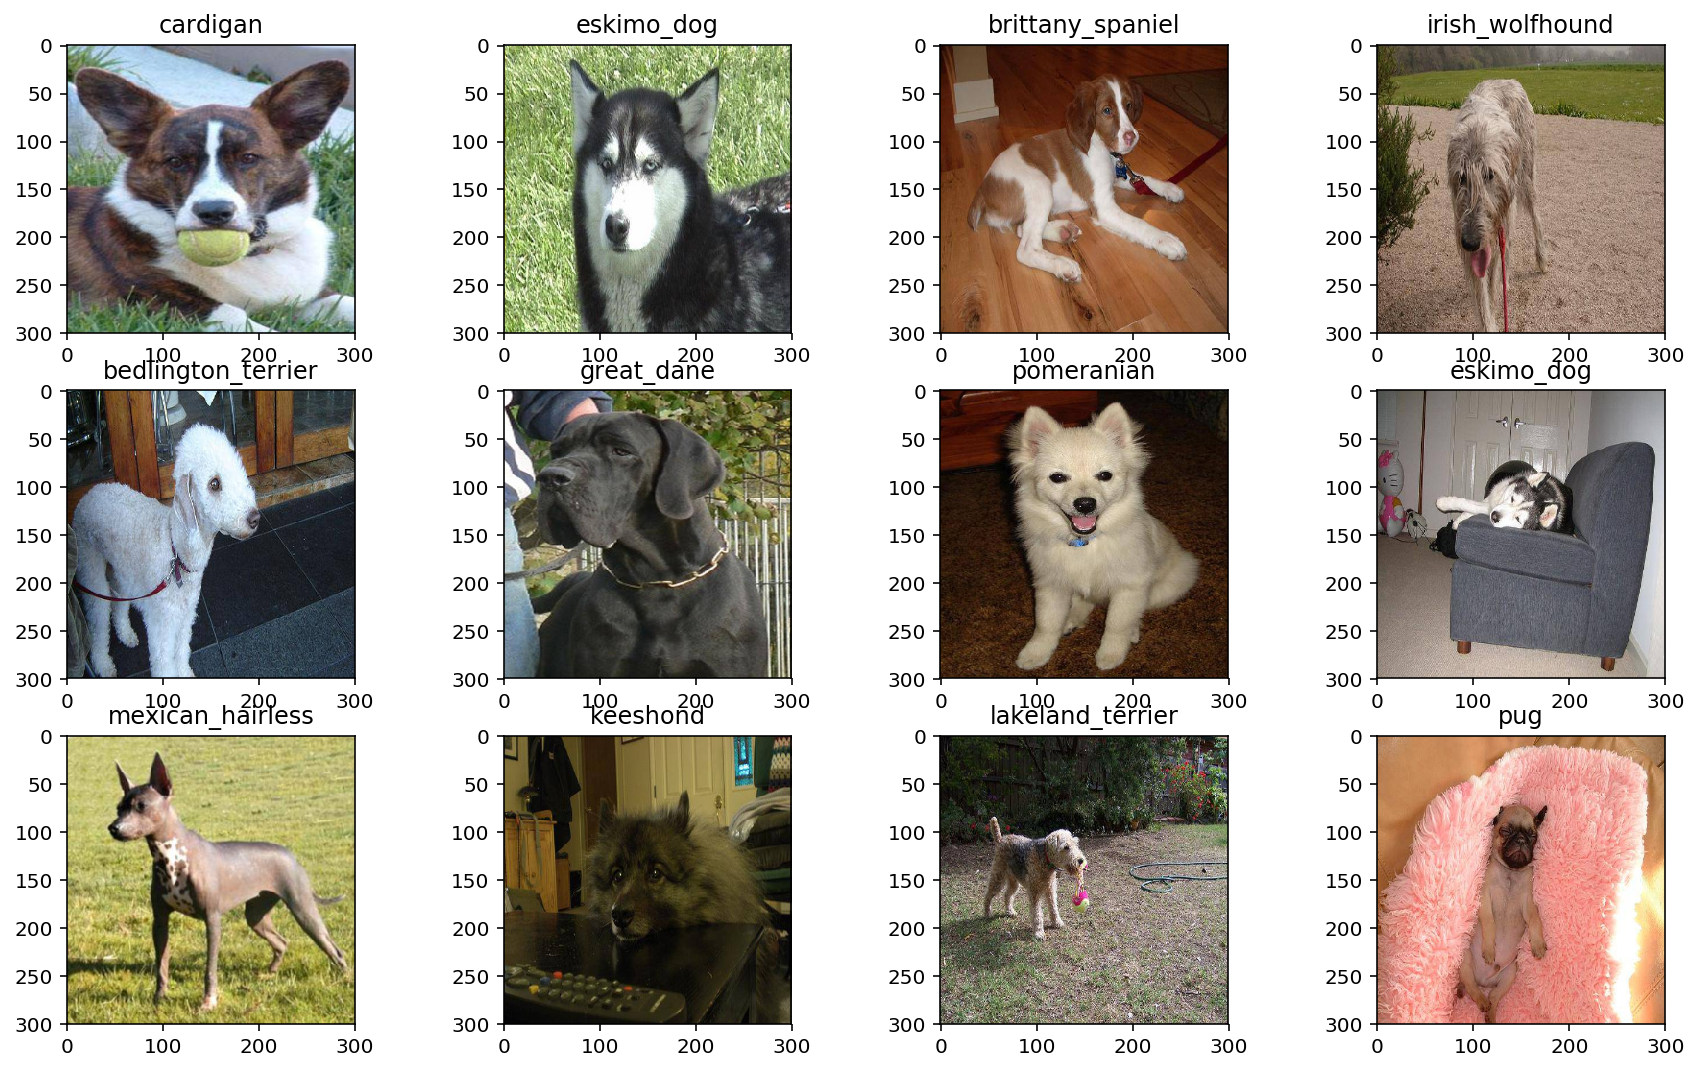

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize = (15, 9))
for i in range(12):
    index = random.randint(0, len_train - 1)
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_train[index][:, :, ::-1])
    plt.title(num_to_class[y_train[index].argmax()])

In [9]:
from keras.models import *
from keras.layers import *

Using TensorFlow backend.


In [10]:
from keras.applications import resnet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [11]:
resnet_model = resnet50.ResNet50(include_top = False, weights='imagenet', input_shape = (300, 300, 3))
    
inputs = Input((width, width, 3))
x = inputs
x = resnet_model(x)
x = GlobalAveragePooling2D()(x)
resnet_model = Model(inputs, x)

resnet_model.summary()

94658560/94653016 [==============================] - 11s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [12]:

features = resnet_model.predict(X_train, batch_size=64, verbose=1)

10222/10222 [==============================] - 79s 8ms/step


In [33]:
features.shape

(10222, 2048)

In [13]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 245,880
Trainable params: 245,880
Non-trainable params: 0
_________________________________________________________________


In [34]:

h = model.fit(features, y_train, batch_size=128, epochs=50, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9199/9199 [==============================] - 0s 39us/step - loss: 0.3317 - acc: 0.8997 - val_loss: 0.7651 - val_acc: 0.7615
Epoch 2/50
9199/9199 [==============================] - 0s 36us/step - loss: 0.3067 - acc: 0.9134 - val_loss: 0.7645 - val_acc: 0.7664
Epoch 3/50
9199/9199 [==============================] - 0s 37us/step - loss: 0.2794 - acc: 0.9215 - val_loss: 0.7628 - val_acc: 0.7703
Epoch 4/50
9199/9199 [==============================] - 0s 35us/step - loss: 0.2644 - acc: 0.9256 - val_loss: 0.7737 - val_acc: 0.7693
Epoch 5/50
9199/9199 [==============================] - 0s 37us/step - loss: 0.2414 - acc: 0.9327 - val_loss: 0.7799 - val_acc: 0.7693
Epoch 6/50
9199/9199 [==============================] - 0s 38us/step - loss: 0.2291 - acc: 0.9335 - val_loss: 0.7780 - val_acc: 0.7615
Epoch 7/50
9199/9199 [==============================] - 0s 36us/step - loss: 0.2181 - acc: 0.9390 - val_loss: 0.7816 - val_acc: 0.7615
Epoch 8

Text(0.5,0,'epoch')

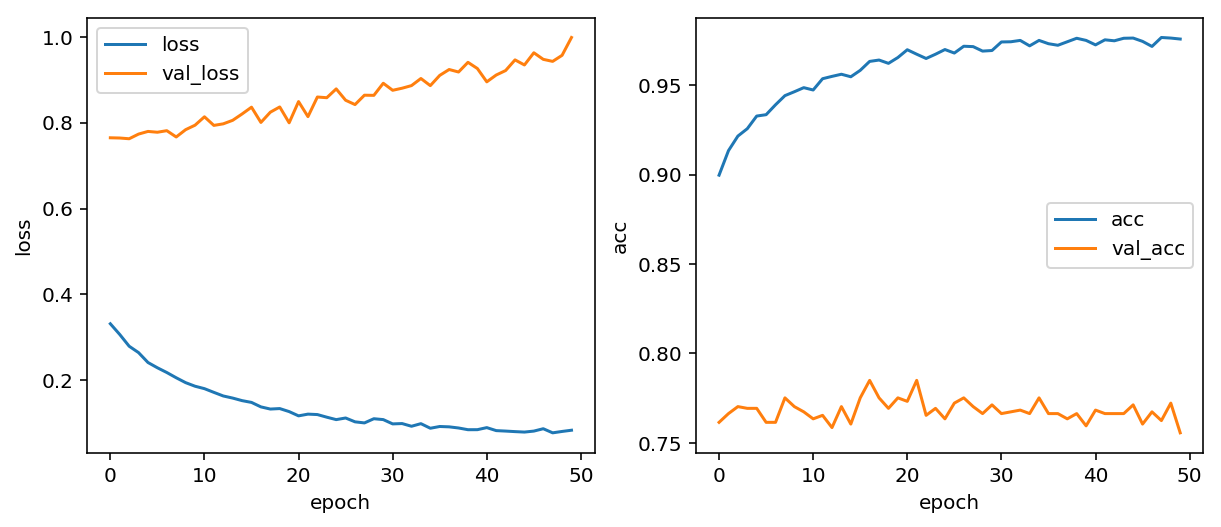

In [35]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [36]:
test_data = pd.read_csv(path_result_csv)


In [17]:
n_test = len(test_data)
X_test = np.zeros((len_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(len_test)):
    X_test[i] = cv2.resize(cv2.imread(os.path.join(path_test, '%s.jpg' % test_data['id'][i])), (width, width))

100%|██████████| 10357/10357 [00:29<00:00, 355.15it/s]


In [18]:
features_test = resnet_model.predict(X_test, batch_size=64, verbose=1)

10357/10357 [==============================] - 76s 7ms/step


In [37]:
y_pred = model.predict(features_test, batch_size=128)

for b in breed:
    test_data[b] = y_pred[:,class_to_num[b]]
    
test_data.to_csv('pred.csv', index=None)

In [38]:
result=pd.read_csv('pred.csv')

In [22]:
result.T

,0,1,2,3,4,5,6,7,8,9,...,10347,10348,10349,10350,10351,10352,10353,10354,10355,10356
id,000621fb3cbb32d8935728e48679680e,00102ee9d8eb90812350685311fe5890,0012a730dfa437f5f3613fb75efcd4ce,001510bc8570bbeee98c8d80c8a95ec1,001a5f3114548acdefa3d4da05474c2e,00225dcd3e4d2410dd53239f95c0352f,002c2a3117c2193b4d26400ce431eebd,002c58d413a521ae8d1a5daeb35fc803,002f80396f1e3db687c5932d7978b196,0036c6bcec6031be9e62a257b1c3c442,...,ffd87c3e44faa0e3ee5fbbdc4c63b59b,ffe2315cf566e039516f5a4a5e52ff1b,ffe42f4b4c50d4f18c2b34500f391152,ffe563b1b8c0dcd0797c4362c6754b96,ffe9717b7937c262f849416976f7620a,ffeda8623d4eee33c6d1156a2ecbfcf8,fff1ec9e6e413275984966f745a313b0,fff74b59b758bbbf13a5793182a9bbe4,fff7d50d848e8014ac1e9172dc6762a3,fffbff22c1f51e3dc80c4bf04089545b
affenpinscher,8.27882e-08,6.49008e-08,5.91708e-06,0.0293829,0.000928493,1.66965e-05,4.87421e-09,3.31238e-07,1.11666e-05,8.20257e-10,...,7.26257e-08,5.21285e-05,3.46562e-10,0.000930319,2.58124e-06,3.88474e-08,8.05444e-06,1.75764e-07,0.00560064,2.98771e-06
afghan_hound,1.66406e-05,4.63917e-09,0.0010876,0.00763087,0.000183919,0.006908,2.44172e-08,2.72057e-08,4.27425e-06,2.12615e-08,...,4.13857e-09,1.05642e-06,8.48338e-05,0.00257989,6.40086e-05,0.000429716,0.00022244,2.90562e-08,0.000204217,0.00146829
african_hunting_dog,6.39744e-10,8.32662e-07,7.1151e-07,4.13891e-06,1.98191e-07,1.12837e-09,1.81941e-10,8.1872e-07,4.47524e-07,1.85261e-09,...,3.22077e-05,5.81203e-08,4.41195e-10,1.09558e-05,0.000975048,3.11221e-07,0.000134109,6.84182e-05,9.52794e-08,2.35158e-06
airedale,3.91002e-11,1.57665e-08,3.80808e-05,0.000547485,4.39086e-06,0.000932991,1.40565e-08,6.8616e-08,0.00204814,4.889e-08,...,5.87511e-08,1.83138e-06,1.26361e-08,0.00263253,0.00438431,3.92469e-06,0.00537036,2.49098e-08,2.74911e-07,3.69029e-06
american_staffordshire_terrier,9.07764e-11,8.42364e-07,4.90732e-07,1.57798e-05,8.26191e-07,4.86752e-08,4.32824e-10,1.44054e-08,1.55251e-08,5.965e-08,...,2.47059e-07,2.94466e-06,1.97875e-09,3.53491e-05,1.77927e-05,2.37361e-07,0.00525442,6.16457e-08,2.85008e-06,1.75556e-07
appenzeller,6.77178e-10,1.69854e-06,9.92048e-06,0.00376085,1.07215e-06,6.40108e-09,3.32382e-09,6.52226e-07,7.63957e-10,1.21463e-09,...,1.461e-06,3.38485e-07,4.7827e-09,0.0001397,0.00429409,2.50651e-08,0.000183325,7.43176e-07,1.60204e-05,1.95644e-07
australian_terrier,1.49484e-08,3.43671e-06,2.04016e-07,7.88749e-06,0.000217894,1.99108e-07,0.997023,3.31232e-05,1.2115e-05,2.91412e-07,...,2.82398e-06,2.64098e-05,8.18341e-09,0.00111295,5.97731e-05,5.53793e-09,1.06683e-05,3.10015e-06,0.000419915,2.97248e-07
basenji,2.38101e-10,1.66507e-07,1.00074e-07,0.000121533,8.55834e-08,8.5488e-05,4.06784e-09,9.42946e-08,8.93321e-11,6.38236e-12,...,0.000187685,3.45087e-09,1.18662e-08,4.00858e-06,1.42505e-05,6.43077e-07,0.000103384,0.000316573,1.94747e-06,2.17298e-07
basset,5.0501e-09,5.71247e-09,3.80999e-05,0.000102406,2.71301e-07,5.84123e-08,1.82427e-10,5.13643e-10,3.38612e-12,8.15958e-09,...,1.64854e-07,2.40477e-08,3.91483e-08,1.90025e-05,0.000521136,1.26218e-08,0.000808856,3.12974e-08,5.90076e-05,2.79579e-09


In [26]:
result.T.drop('id',inplace=True)

In [28]:
result=result.T.drop('id')

In [29]:
result

,0,1,2,3,4,5,6,7,8,9,...,10347,10348,10349,10350,10351,10352,10353,10354,10355,10356
affenpinscher,8.27882e-08,6.49008e-08,5.91708e-06,0.0293829,0.000928493,1.66965e-05,4.87421e-09,3.31238e-07,1.11666e-05,8.20257e-10,...,7.26257e-08,5.21285e-05,3.46562e-10,0.000930319,2.58124e-06,3.88474e-08,8.05444e-06,1.75764e-07,0.00560064,2.98771e-06
afghan_hound,1.66406e-05,4.63917e-09,0.0010876,0.00763087,0.000183919,0.006908,2.44172e-08,2.72057e-08,4.27425e-06,2.12615e-08,...,4.13857e-09,1.05642e-06,8.48338e-05,0.00257989,6.40086e-05,0.000429716,0.00022244,2.90562e-08,0.000204217,0.00146829
african_hunting_dog,6.39744e-10,8.32662e-07,7.1151e-07,4.13891e-06,1.98191e-07,1.12837e-09,1.81941e-10,8.1872e-07,4.47524e-07,1.85261e-09,...,3.22077e-05,5.81203e-08,4.41195e-10,1.09558e-05,0.000975048,3.11221e-07,0.000134109,6.84182e-05,9.52794e-08,2.35158e-06
airedale,3.91002e-11,1.57665e-08,3.80808e-05,0.000547485,4.39086e-06,0.000932991,1.40565e-08,6.8616e-08,0.00204814,4.889e-08,...,5.87511e-08,1.83138e-06,1.26361e-08,0.00263253,0.00438431,3.92469e-06,0.00537036,2.49098e-08,2.74911e-07,3.69029e-06
american_staffordshire_terrier,9.07764e-11,8.42364e-07,4.90732e-07,1.57798e-05,8.26191e-07,4.86752e-08,4.32824e-10,1.44054e-08,1.55251e-08,5.965e-08,...,2.47059e-07,2.94466e-06,1.97875e-09,3.53491e-05,1.77927e-05,2.37361e-07,0.00525442,6.16457e-08,2.85008e-06,1.75556e-07
appenzeller,6.77178e-10,1.69854e-06,9.92048e-06,0.00376085,1.07215e-06,6.40108e-09,3.32382e-09,6.52226e-07,7.63957e-10,1.21463e-09,...,1.461e-06,3.38485e-07,4.7827e-09,0.0001397,0.00429409,2.50651e-08,0.000183325,7.43176e-07,1.60204e-05,1.95644e-07
australian_terrier,1.49484e-08,3.43671e-06,2.04016e-07,7.88749e-06,0.000217894,1.99108e-07,0.997023,3.31232e-05,1.2115e-05,2.91412e-07,...,2.82398e-06,2.64098e-05,8.18341e-09,0.00111295,5.97731e-05,5.53793e-09,1.06683e-05,3.10015e-06,0.000419915,2.97248e-07
basenji,2.38101e-10,1.66507e-07,1.00074e-07,0.000121533,8.55834e-08,8.5488e-05,4.06784e-09,9.42946e-08,8.93321e-11,6.38236e-12,...,0.000187685,3.45087e-09,1.18662e-08,4.00858e-06,1.42505e-05,6.43077e-07,0.000103384,0.000316573,1.94747e-06,2.17298e-07
basset,5.0501e-09,5.71247e-09,3.80999e-05,0.000102406,2.71301e-07,5.84123e-08,1.82427e-10,5.13643e-10,3.38612e-12,8.15958e-09,...,1.64854e-07,2.40477e-08,3.91483e-08,1.90025e-05,0.000521136,1.26218e-08,0.000808856,3.12974e-08,5.90076e-05,2.79579e-09
beagle,5.39368e-08,7.83018e-07,4.86063e-05,0.000398948,3.52936e-07,2.56897e-07,1.00197e-10,1.12469e-08,5.5296e-10,7.40422e-08,...,9.65955e-08,3.44856e-09,1.01916e-08,2.72994e-05,0.0010135,1.25048e-06,0.000704612,7.19131e-07,1.31113e-05,1.1395e-07


In [30]:
result>0.5

,0,1,2,3,4,5,6,7,8,9,...,10347,10348,10349,10350,10351,10352,10353,10354,10355,10356
affenpinscher,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
afghan_hound,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
african_hunting_dog,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
airedale,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
american_staffordshire_terrier,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
appenzeller,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
australian_terrier,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
basenji,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
basset,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
beagle,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
